2.1. Load: Read the raw data acquired in Section 1

In [11]:
# Import all necessary Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
!pip install country_converter # Install country_converter if not already installed
import country_converter as coco
from sklearn.preprocessing import MinMaxScaler


In [12]:
df = pd.read_csv('cwur_rankings_2025.csv')

df.head(10)

Saving cwur_rankings_2025.csv to cwur_rankings_2025 (1).csv


,World Rank,Institution,Location,National Rank,Education Rank,Employability Rank,Faculty Rank,Research Rank,Score
0,1 Top 0.1%,Harvard University,USA,1,1,1,1,1,100.0
1,2 Top 0.1%,Massachusetts Institute of Technology,USA,2,4,12,2,11,96.8
2,3 Top 0.1%,Stanford University,USA,3,10,4,3,4,95.2
3,4 Top 0.1%,University of Cambridge,United Kingdom,1,2,26,4,14,94.1
4,5 Top 0.1%,University of Oxford,United Kingdom,2,7,28,9,6,93.3
5,6 Top 0.1%,Princeton University,USA,4,5,15,8,87,92.7
6,7 Top 0.1%,University of Pennsylvania,USA,5,16,7,29,12,92.1
7,8 Top 0.1%,Columbia University,USA,6,12,14,10,15,91.6
8,9 Top 0.1%,Yale University,USA,7,6,31,14,24,91.2
9,10 Top 0.1%,University of Chicago,USA,8,8,16,22,50,90.8


# 2.2 Handling Missing Data: Identify and handle missing rank values (e.g., impute a placeholder or remove the row, with justification).

In [13]:
# Count missing values in each column
df.isnull().sum()

,0
World Rank,0
Institution,0
Location,0
National Rank,0
Education Rank,0
Employability Rank,0
Faculty Rank,29
Research Rank,0
Score,0


In [14]:
# Convert all dashes in the DataFrame to NaN
df1 = df.replace('-', pd.NA)

# Count all missing values, including former dashes
missing = df1.isna().sum()
print(missing)


World Rank               0
Institution              0
Location                 0
National Rank            0
Education Rank        1554
Employability Rank     962
Faculty Rank          1722
Research Rank           68
Score                    0
dtype: int64


# Summary of dataframe

=== Column Types ===
World Rank             object
Institution            object
Location               object
National Rank           int64
Education Rank         object
Employability Rank     object
Faculty Rank           object
Research Rank          object
Score                 float64
dtype: object


=== Numeric Columns Summary ===
       National Rank       Score
count    2000.000000  2000.00000
mean       71.676000    71.95580
std        89.229003     4.99187
min         1.000000    66.20000
25%        10.000000    68.10000
50%        33.000000    70.60000
75%        91.000000    74.40000
max       346.000000   100.00000


=== Categorical Columns Summary ===
           World Rank            Institution Location Education Rank  \
count            2000                   2000     2000            446   
unique           2000                   2000       94            446   
top     1984 Top 9.3%  Mid Sweden University    China            351   
freq                1                 

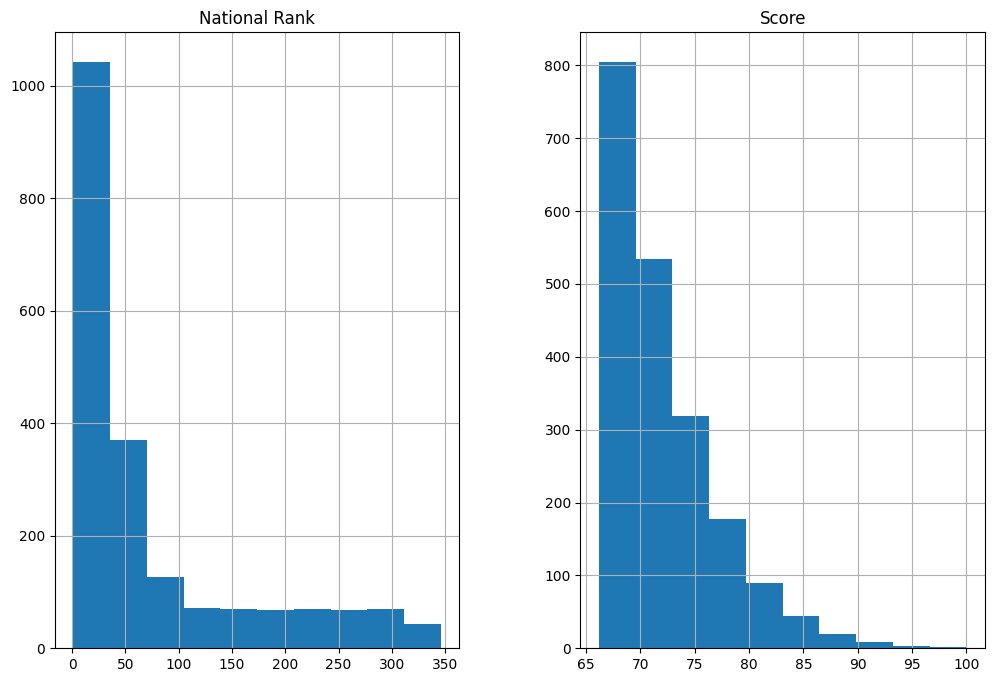

In [15]:
#Display columns types
print("=== Column Types ===")
print(df1.dtypes)
print("\n")

# Describe Numeric columns
print("=== Numeric Columns Summary ===")
numeric_summary = df1.describe()
print(numeric_summary)
print("\n")

#Summarize categorical columns
print("=== Categorical Columns Summary ===")
categorical_summary = df1.describe(include='object')
print(categorical_summary)
print("\n")

# Check for missing values in the data
print("=== Missing Values per Column ===")
missing_counts = df1.isna().sum()
missing_percent = (missing_counts / len(df1)) * 100
missing_df = pd.DataFrame({'Missing_Count': missing_counts, 'Missing_%': missing_percent})
print(missing_df)
print("\n")

# Check for duplicate data
print("=== Duplicate Rows ===")
num_duplicates = df1.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")
print("\n")

#Get unique values for categorical columns
print("=== Unique Values for Categorical Columns ===")
categorical_cols = df1.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"{col}: {df1[col].nunique()} unique values")
print("\n")

# Plot the distribution for the numeric columns
df1.hist(figsize=(12, 8))
plt.show()


# Handling missing values by deleting the column

In [16]:
# Drop columns with more than 75% missing values
df2 = df1.drop(columns=['Education Rank', 'Faculty Rank'])


In [17]:
# Check datatypes of all columns
print(df2.dtypes)

World Rank             object
Institution            object
Location               object
National Rank           int64
Employability Rank     object
Research Rank          object
Score                 float64
dtype: object


# Handling missing values by imputing using the median value of the column data

In [18]:
# Define columns to clean and convert to numeric
cols_to_numeric = ['Employability Rank', 'Research Rank']

# Remove all non-digit characters and convert to numeric
for col in cols_to_numeric:
    df2[col] = pd.to_numeric(
        df2[col].astype(str).str.extract(r'(\d+)')[0],  # Extract digits
        errors='coerce'  # Convert non-numeric entries into NaN
    )

# Display mean, median, and mode for each cleaned column
for col in cols_to_numeric:
    mean_val = df2[col].mean()
    median_val = df2[col].median()
    mode_val = df2[col].mode()[0]
    print(f"{col} -> Mean: {mean_val}, Median: {median_val}, Mode: {mode_val}")

# Fill missing values in 'Research Rank' using median (only 4.5% missing)
df2['Research Rank'] = df2['Research Rank'].fillna(df2['Research Rank'].median())


Employability Rank -> Mean: 806.8969171483623, Median: 787.5, Mode: 1672.0
Research Rank -> Mean: 966.6444099378882, Median: 966.5, Mode: 1.0


# Handling missing values by imputing using a machine a model since it ordinal data and 48% missingness

In [19]:
#select dependent and independent variables
numeric_cols = ['National Rank', 'Research Rank', 'Score']
target_col = 'Employability Rank'

# Prepare dataframe for imputation
impute_df = df2[numeric_cols + [target_col]]

# Define Iterative Imputer with Random Forest
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    max_iter=10, random_state=42)

# Fit and transform the data
imputed_array = imputer.fit_transform(impute_df)

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed_array, columns=impute_df.columns)

# Replace original 'Employability Rank' with imputed values
df2['Employability Rank'] = imputed_df['Employability Rank']

# Check missing values after imputation
print(df2['Employability Rank'].isna().sum())

# Step 4: Verify no missing values remain
print(df2[cols_to_numeric].isna().sum())

0
Employability Rank    0
Research Rank         0
dtype: int64


# 2.3.Data Type Conversion: Convert the Rank and all Score columns (e.g., Academic Reputation, Faculty/Student Ratio) from strings to appropriate numeric types (float or int). This will require handling non-numeric characters (e.g., '101-150', 'N/A', '†').

In [20]:
# Split the 'World Rank' column into two parts
df2[['World Rank1', 'Global_Percentile(%)']] = df2['World Rank'].str.split(' ', n=1, expand=True)

# Use regex to extract numeric rank and numeric percentage from 'World Rank'
df2[['World Rank1', 'Global_Percentile(%)']] = df2['World Rank'].str.extract(r'(\d+)\s+Top\s+(\d+\.?\d*)')

# Convert extracted values to proper numeric types
df2['World Rank1'] = df2['World Rank1'].astype(int)
df2['Global_Percentile(%)'] = df2['Global_Percentile(%)'].astype(float)

# View the cleaned result
print(df2[['World Rank', 'World Rank1', 'Global_Percentile(%)']].head())



   World Rank  World Rank1  Global_Percentile(%)
0  1 Top 0.1%            1                   0.1
1  2 Top 0.1%            2                   0.1
2  3 Top 0.1%            3                   0.1
3  4 Top 0.1%            4                   0.1
4  5 Top 0.1%            5                   0.1


In [21]:
df2.dtypes

,0
World Rank,object
Institution,object
Location,object
National Rank,int64
Employability Rank,float64
Research Rank,float64
Score,float64
World Rank1,int64
Global_Percentile(%),float64


# 2.4.Feature Engineering:
Create a new categorical column, Global_Region, based on the Country column (e.g., 'North America', 'Europe', 'Asia', 'Oceania')

In [22]:
# Create a converter object
cc = coco.CountryConverter()

# Convert Location to continent and store in a new column 'Global_Region'
df2['Global_Region'] = cc.convert(names=df['Location'], to='continent')

In [23]:
df2

,World Rank,Institution,Location,National Rank,Employability Rank,Research Rank,Score,World Rank1,Global_Percentile(%),Global_Region
0,1 Top 0.1%,Harvard University,USA,1,1.00,1.0,100.0,1,0.1,America
1,2 Top 0.1%,Massachusetts Institute of Technology,USA,2,12.00,11.0,96.8,2,0.1,America
2,3 Top 0.1%,Stanford University,USA,3,4.00,4.0,95.2,3,0.1,America
3,4 Top 0.1%,University of Cambridge,United Kingdom,1,26.00,14.0,94.1,4,0.1,Europe
4,5 Top 0.1%,University of Oxford,United Kingdom,2,28.00,6.0,93.3,5,0.1,Europe
...,...,...,...,...,...,...,...,...,...,...
1995,1996 Top 9.4%,Hunan University of Technology,China,344,1173.92,1920.0,66.2,1996,9.4,Asia
1996,1997 Top 9.4%,Guizhou Normal University,China,345,1173.92,1922.0,66.2,1997,9.4,Asia
1997,1998 Top 9.4%,Bengbu Medical University,China,346,1165.36,1924.0,66.2,1998,9.4,Asia
1998,1999 Top 9.4%,Federal University of Amazonas,Brazil,53,1194.81,1925.0,66.2,1999,9.4,America


#2.4 Create a normalized numeric column, Overall_Score_Normalized, by scaling the main ranking score column to a range between 0 and 1.

In [24]:
# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform the Score column, reshaping needed for a single column
df2['Score_Normalized'] = scaler.fit_transform(df2[['Score']]).round(4)

# Optional: check the result
print(df2[['Score', 'Score_Normalized']].head())


   Score  Score_Normalized
0  100.0            1.0000
1   96.8            0.9053
2   95.2            0.8580
3   94.1            0.8254
4   93.3            0.8018


In [25]:
#Rearrage columns
df2 = df2[['Institution', 'Location', 'Global_Region','World Rank', 'World Rank1','Global_Percentile(%)',
         'National Rank', 'Employability Rank', 'Research Rank',
         'Score', 'Score_Normalized']]



In [26]:
#Preview the dataframe
df2

,Institution,Location,Global_Region,World Rank,World Rank1,Global_Percentile(%),National Rank,Employability Rank,Research Rank,Score,Score_Normalized
0,Harvard University,USA,America,1 Top 0.1%,1,0.1,1,1.00,1.0,100.0,1.0000
1,Massachusetts Institute of Technology,USA,America,2 Top 0.1%,2,0.1,2,12.00,11.0,96.8,0.9053
2,Stanford University,USA,America,3 Top 0.1%,3,0.1,3,4.00,4.0,95.2,0.8580
3,University of Cambridge,United Kingdom,Europe,4 Top 0.1%,4,0.1,1,26.00,14.0,94.1,0.8254
4,University of Oxford,United Kingdom,Europe,5 Top 0.1%,5,0.1,2,28.00,6.0,93.3,0.8018
...,...,...,...,...,...,...,...,...,...,...,...
1995,Hunan University of Technology,China,Asia,1996 Top 9.4%,1996,9.4,344,1173.92,1920.0,66.2,0.0000
1996,Guizhou Normal University,China,Asia,1997 Top 9.4%,1997,9.4,345,1173.92,1922.0,66.2,0.0000
1997,Bengbu Medical University,China,Asia,1998 Top 9.4%,1998,9.4,346,1165.36,1924.0,66.2,0.0000
1998,Federal University of Amazonas,Brazil,America,1999 Top 9.4%,1999,9.4,53,1194.81,1925.0,66.2,0.0000


In [27]:
# Check if there are any exact duplicate rows
duplicates = df2.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicate rows if any
df2 = df2.drop_duplicates()


Number of duplicate rows: 0


In [28]:
# Check for duplicate primary keys
primary_key_duplicates = df2.duplicated(subset=['Institution'])
print(f"Number of duplicate primary keys: {primary_key_duplicates.sum()}")


# Should be True if all primary keys are unique
print(df2[['Institution']].duplicated().sum() == 0)


Number of duplicate primary keys: 0
True


In [29]:
#Remove traling spaces
df2['Institution'] = df2['Institution'].str.strip()


In [30]:
print("Any row duplicates left?", df2.duplicated().any())
print("Any primary key duplicates left?", df2.duplicated(subset=['Institution']).any())


Any row duplicates left? False
Any primary key duplicates left? False


In [31]:
#Save the cleaned data to csv
df2.to_csv('df2_clean.csv', index=False)